In [1]:
# Standard library imports
import os
import sys
import time
import json
import warnings
import logging
import pickle
import hashlib
from abc import abstractmethod
from datetime import datetime, timedelta
from math import pi
from typing import Optional
from joblib import dump, load

# Third-party imports
import requests
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.signal import detrend
from scipy.stats import jarque_bera, kstest
#from scipy.stats import boxcox, invboxcox  # Uncomment if needed
from cryptocmd import CmcScraper
from prettytable import PrettyTable
from pandas.tseries.holiday import USFederalHolidayCalendar
from arch import arch_model

# Plotting and Visualization
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import (HoverTool, ColumnDataSource, WheelZoomTool, Span, Range1d,
                          FreehandDrawTool, MultiLine, NumeralTickFormatter, Button, CustomJS)
from bokeh.layouts import column, row
from bokeh.io import curdoc, export_png
from bokeh.models.widgets import CheckboxGroup
from bokeh.themes import Theme
from IPython.display import display, HTML

# Machine Learning Libraries
import sklearn
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
import xgboost as xgb
from statsmodels.tsa.api import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, LSTM, TimeDistributed, Conv1D, MaxPooling1D, Flatten,
                                    ConvLSTM2D, BatchNormalization, GRU, Bidirectional, Attention, Input,
                                    Reshape, GlobalAveragePooling1D, GlobalMaxPooling1D, Lambda, LayerNormalization, 
                                    SimpleRNN, Layer, Multiply, Add, Activation)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1, l2, l1_l2
from keras_tuner import HyperModel, RandomSearch, BayesianOptimization
from tcn import TCN
from kerasbeats import NBeatsModel
from typing import List, Optional
from typing import Optional, List, Tuple
from statsmodels.tsa.stattools import acf, pacf


2023-10-28 17:52:58.319815: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-28 17:52:58.319946: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-28 17:52:58.320072: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-28 17:52:58.351864: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


In [2]:
# Other settings
from IPython.display import display, HTML
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.3f}'.format)
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] - %(message)s')
logger = logging.getLogger(__name__)
display(HTML("<style>.bk-root { margin-left: auto; margin-right: auto; }</style>"))

print("Hello Everyone")
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sklearn.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Hello Everyone
Tensor Flow Version: 2.14.0
Keras Version: 2.14.0

Python 3.9.18 (main, Sep 11 2023, 13:41:44) 
[GCC 11.2.0]
Pandas 2.1.1
Scikit-Learn 1.3.1
GPU is available


2023-10-28 17:53:02.506356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-28 17:53:02.907755: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-28 17:53:02.907851: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
class CryptoData:
    """
    The CryptoData class is responsible for fetching and validating cryptocurrency data. 
    It provides methods to fetch raw data, validate its integrity, and format it for display.
    
    Attributes:
    - EXPECTED_COLUMNS: A set of expected columns in the fetched data.
    - crypto_symbols: A list of cryptocurrency symbols to fetch.
    - retries: The maximum number of data fetch retries.
    - backoff_factor: The exponential backoff factor for retries.
    """
    
    EXPECTED_COLUMNS = {'Date', 'Open', 'High', 'Low', 'Close', 'Market Cap', 'Volume'}

    def __init__(self, crypto_symbols: list[str], retries: int = 5, backoff_factor: float = 0.3):
        """Initializes the class with the given list of cryptocurrency symbols."""
        logger.info("Initializing CryptoData class.")
        self.crypto_symbols = crypto_symbols
        self.retries = retries
        self.backoff_factor = backoff_factor
        self.DATA_DIR = "crypto_assets"
        if not os.path.exists(self.DATA_DIR):
            os.makedirs(self.DATA_DIR)
        logger.info("CryptoData class initialized.")

    def _fetch_cryptocmd_data(self, symbol: str) -> pd.DataFrame:
        """Fetches cryptocurrency data with retries and exponential backoff."""
        logger.info(f"Fetching data for {symbol}.")
        scraper = CmcScraper(symbol)
        df = scraper.get_dataframe()

        # Drop unwanted columns
        unwanted_columns = ['Time Open', 'Time High', 'Time Low', 'Time Close']
        df.drop(columns=unwanted_columns, inplace=True)
        
        # Sort data by Date in ascending order
        df.sort_values(by='Date', ascending=True, inplace=True)
        return df

    def _local_data_path(self, symbol: str) -> str:
        return os.path.join(self.DATA_DIR, f"data_c_{symbol}.csv")

    def get_cryptocmd_data(self, symbol: str, overwrite: bool = False) -> pd.DataFrame:
        """Fetches and returns the cryptocurrency data."""
        logger.info(f"Retrieving {symbol} data.")
        df = self._fetch_cryptocmd_data(symbol)
        
        # Save to local storage if needed
        file_path = self._local_data_path(symbol)
        if overwrite or not os.path.exists(file_path):
            df.to_csv(file_path, index=False)
        
        # Set 'Date' as the index
        df.set_index('Date', inplace=True)
        return df

    def get_all_data(self, overwrite: bool = False) -> dict[str, pd.DataFrame]:
        """Fetches data for all specified cryptocurrencies."""
        logger.info("Getting data for all specified cryptocurrencies.")
        data_dict = {}
        for symbol in self.crypto_symbols:
            data_dict[symbol] = self.get_cryptocmd_data(symbol, overwrite)
        logger.info("All data retrieved successfully.")
        return data_dict

    @staticmethod
    def _format_monetary_value(value: float) -> str:
        """Formats a monetary value to a string."""
        return "${:,.2f}".format(value)

    @staticmethod
    def _format_volume_value(value: float) -> str:
        """Formats a volume value to a string."""
        if value > 1e9:
            return "{:.2f}B".format(value/1e9)
        elif value > 1e6:
            return "{:.2f}M".format(value/1e6)
        else:
            return "{:,.2f}".format(value)

    def get_display_data(self, symbol: str) -> pd.DataFrame:
        """Formats the cryptocurrency data for display."""
        logger.info(f"Formatting display data for {symbol}.")
        
        # Load the data for the given symbol from local storage
        file_path = self._local_data_path(symbol)
        if not os.path.exists(file_path):
            raise ValueError(f"No data found for {symbol}. Please fetch the data first.")
        display_df = pd.read_csv(file_path, parse_dates=['Date']).set_index('Date')
        
        # Format the data
        monetary_columns = ['Open', 'High', 'Low', 'Close']
        display_df[monetary_columns] = display_df[monetary_columns].applymap(self._format_monetary_value)
        volume_like_columns = ['Volume', 'Market Cap']
        display_df[volume_like_columns] = display_df[volume_like_columns].applymap(self._format_volume_value)
        logger.info(f"Display data formatted successfully for {symbol}.")
        return display_df

In [4]:
crypto_data_obj = CryptoData(['BTC', 'ETH', 'ADA'])
all_data = crypto_data_obj.get_all_data(overwrite=True)
btc_data, eth_data, ada_data = all_data['BTC'], all_data['ETH'], all_data['ADA']
btc_display_data = crypto_data_obj.get_display_data('BTC')

2023-10-28 17:53:03,381 [INFO] - Initializing CryptoData class.
2023-10-28 17:53:03,388 [INFO] - CryptoData class initialized.
2023-10-28 17:53:03,390 [INFO] - Getting data for all specified cryptocurrencies.
2023-10-28 17:53:03,391 [INFO] - Retrieving BTC data.
2023-10-28 17:53:03,392 [INFO] - Fetching data for BTC.
2023-10-28 17:53:05,819 [INFO] - Retrieving ETH data.
2023-10-28 17:53:05,820 [INFO] - Fetching data for ETH.
2023-10-28 17:53:08,114 [INFO] - Retrieving ADA data.
2023-10-28 17:53:08,116 [INFO] - Fetching data for ADA.
2023-10-28 17:53:09,837 [INFO] - All data retrieved successfully.
2023-10-28 17:53:09,838 [INFO] - Formatting display data for BTC.
2023-10-28 17:53:10,294 [INFO] - Display data formatted successfully for BTC.


In [5]:
df = btc_data.copy()

In [6]:
class UnifiedDataPreprocessor:
    """ 
    UnifiedDataPreprocessor is responsible for preprocessing time series data.
    It performs actions like data splitting, normalization, reshaping, and sequence generation.
    
    Attributes:
        data (pd.DataFrame): Original time series data.
        target_column (str): Target column for preprocessing.
        logger (logging.Logger): Logger for tracking operations and debugging.
        transformations (list): List of applied transformations.
    """
    
    def __init__(self, df, target_column, logger=None):
        self.data = df.copy()
        self.target_column = target_column
        self.scalers = {}
        self.X_train, self.X_test, self.y_train, self.y_test = None, None, None, None
        self.X_train_seq, self.X_test_seq, self.y_train_seq, self.y_test_seq = None, None, None, None
        self.logger = logger if logger else logging.getLogger(__name__)
        self.transformations = []
        self.lambda_val = None  
        self.scalers = {
            "MinMax": MinMaxScaler(),
            "Standard": StandardScaler(),
            "Robust": RobustScaler(),
            "Quantile": QuantileTransformer(output_distribution='normal'),
            "Power": PowerTransformer(method='yeo-johnson')
        }
        self.logger.info("Initializing DataPreprocessor...")        
    
    def get_scaler(self, scaler_type: str):
        self.logger.info(f"Getting scaler of type: {scaler_type}")
        try:
            return self.scalers[scaler_type]
        except KeyError:
            raise ValueError(f"Invalid scaler_type. Supported types are: {', '.join(self.scalers.keys())}")

    def split_and_plot_data(self, test_size: float = 0.2, split_date: Optional[str] = None, plot: bool = True):
        self.logger.info("Splitting data...")
        self.transformations.append('Data Splitting')
        features = self.data.drop(columns=[self.target_column])
        target = self.data[self.target_column]

        if split_date:
            train_mask = self.data.index < split_date
            self.X_train, self.X_test = features[train_mask], features[~train_mask]
            self.y_train, self.y_test = target[train_mask], target[~train_mask]
        else:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                features, target, test_size=test_size, shuffle=False
            )

        self.logger.info(f"Data split completed. X_train shape: {self.X_train.shape}, y_train shape: {self.y_train.shape}")

        if plot:
            plt.figure(figsize=(20, 7))
            plt.subplot(1, 2, 1)
            plt.title('Training Data - Target')
            plt.plot(self.y_train, label=self.target_column)
            plt.xlabel("Time")
            plt.ylabel("Value")
            plt.legend()
            plt.subplot(1, 2, 2)
            plt.title('Test Data - Target')
            plt.plot(self.y_test, label=self.target_column)
            plt.xlabel("Time")
            plt.ylabel("Value")
            plt.legend()
            plt.show()

    def normalize_data(self, scaler_type: str = 'MinMax', plot: bool = True):
        self.logger.info("Normalizing feature data...")
        scaler = self.get_scaler(scaler_type)
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)
        self.scalers['features'] = scaler
        self.logger.info("Feature data normalization completed.")
        self.transformations.append(f"Feature normalization with {scaler_type} scaler")

        if plot:
            plt.figure(figsize=(20, 8))
            plt.subplot(1, 2, 1)
            plt.title('Normalized Training Features')
            for i in range(self.X_train.shape[1]):
                plt.plot(self.X_train[:, i], label=f'Feature {i}')
            plt.legend()
            plt.subplot(1, 2, 2)
            plt.title('Normalized Test Features')
            for i in range(self.X_test.shape[1]):
                plt.plot(self.X_test[:, i], label=f'Feature {i}')
            plt.legend()
            plt.show()

    def normalize_target(self, scaler_type: str = 'MinMax', plot: bool = True):
        self.logger.info("Normalizing target data...")
        scaler = self.get_scaler(scaler_type)
        self.y_train = scaler.fit_transform(self.y_train.values.reshape(-1, 1))
        self.y_test = scaler.transform(self.y_test.values.reshape(-1, 1))
        self.scalers['target'] = scaler
        self.logger.info("Target data normalization completed.")
        self.transformations.append(f"Target normalization with {scaler_type} scaler")

        if plot:
            plt.figure(figsize=(20, 7))
            plt.subplot(1, 2, 1)
            plt.title('Normalized Training Target')
            plt.plot(self.y_train, label='Normalized ' + self.target_column)
            plt.legend()
            plt.subplot(1, 2, 2)
            plt.title('Normalized Test Target')
            plt.plot(self.y_test, label='Normalized ' + self.target_column)
            plt.legend()
            plt.show()

    def difference_and_plot_data(self, interval: int = 1, plot: bool = True):
        self.logger.info(f"Applying differencing with interval {interval}...")
        self.data = self.data.diff(periods=interval).dropna()
        self.transformations.append(f'Differencing with interval {interval}')
        self.logger.info("Differencing applied.")
        
        if plot:
            plt.figure(figsize=(20, 7))
            plt.title('Data after Differencing')
            plt.plot(self.data[self.target_column], label=self.target_column)
            plt.legend()
            plt.show()

    def box_cox_transform_and_plot(self, lambda_val: Optional[float] = None, plot: bool = True):
        if self.y_train is None or self.y_test is None:
            self.logger.warning("Data not split yet. Run split_data first.")
            return self  # Allow method chaining

        if np.any(self.y_train <= 0) or np.any(self.y_test <= 0):
            self.logger.warning("Data must be positive for Box-Cox transformation.")
            return self  # Allow method chaining

        self.logger.info("Applying Box-Cox transformation...")
        self.y_train = self.y_train.ravel()
        self.y_test = self.y_test.ravel()
        self.y_train, fitted_lambda = boxcox(self.y_train)
        self.lambda_val = fitted_lambda if lambda_val is None else lambda_val
        self.y_test = boxcox(self.y_test, lmbda=self.lambda_val)
        self.transformations.append(f"Box-Cox transformation with lambda {self.lambda_val}")
        self.logger.info(f"Box-Cox transformation applied with lambda {self.lambda_val}.")

        if plot:
            plt.figure(figsize=(20, 7))
            plt.subplot(1, 2, 1)
            plt.title('Box-Cox Transformed Training Target')
            plt.plot(self.y_train, label='Transformed ' + self.target_column)
            plt.legend()
            plt.subplot(1, 2, 2)
            plt.title('Box-Cox Transformed Test Target')
            plt.plot(self.y_test, label='Transformed ' + self.target_column)
            plt.legend()
            plt.show()

    def inverse_box_cox_and_plot(self, plot: bool = True):
        if "Box-Cox transformation" not in "".join(self.transformations):
            self.logger.warning("No Box-Cox transformation found on the target column. Skipping inverse transformation.")
            return

        self.logger.info("Applying inverse Box-Cox transformation...")
        self.y_train = invboxcox(self.y_train, self.lambda_val)
        self.y_test = invboxcox(self.y_test, self.lambda_val)
        self.transformations.remove(f"Box-Cox transformation with lambda {self.lambda_val}")
        self.logger.info(f"Inverse Box-Cox transformation applied on column {self.target_column}.")
        
        if plot:
            plt.figure(figsize=(20, 7))
            plt.subplot(1, 2, 1)
            plt.title('Inverse Box-Cox Transformed Training Target')
            plt.plot(self.y_train, label='Inverse Transformed ' + self.target_column)
            plt.legend()
            plt.subplot(1, 2, 2)
            plt.title('Inverse Box-Cox Transformed Test Target')
            plt.plot(self.y_test, label='Inverse Transformed ' + self.target_column)
            plt.legend()
            plt.show()

    def reshape_for_recurrent(self, data: np.array) -> np.array:
        self.logger.info("Reshaping data for recurrent models...")
        reshaped_data = data.reshape(data.shape)
        self.logger.info(f"Data reshaped to {reshaped_data.shape}.")
        self.transformations.append('Data Reshaped')
        return reshaped_data

    def generate_sequences(self, X_data: np.array, y_data: np.array, n_steps: int, seq_to_seq: bool = False) -> Tuple[np.array, np.array]:
        X, y = [], []
        for i in range(len(X_data) - n_steps):
            seq_x = X_data[i:i + n_steps, :]
            if seq_to_seq:
                seq_y = y_data[i:i + n_steps, :]
            else:
                seq_y = y_data[i + n_steps - 1]
            X.append(seq_x)
            y.append(seq_y)
        self.logger.info(f"Generated {len(X)} sequences of shape {X[0].shape}.")
        self.transformations.append('Sequences Generated')
        return np.array(X), np.array(y)
    
    def prepare_data_for_recurrent(self, n_steps: int, seq_to_seq: bool = False) -> Tuple[np.array, np.array, np.array, np.array]:
        self.logger.info(f"Preparing data for recurrent models with {n_steps} timesteps...")
        X_train_seq, y_train_seq = self.generate_sequences(self.X_train, self.y_train, n_steps, seq_to_seq)
        X_test_seq, y_test_seq = self.generate_sequences(self.X_test, self.y_test, n_steps, seq_to_seq)

        # Update instance variables here
        self.X_train_seq = self.reshape_for_recurrent(X_train_seq)
        self.X_test_seq = self.reshape_for_recurrent(X_test_seq)
        self.y_train_seq = y_train_seq  # Assuming y_train_seq and y_test_seq are already 2D
        self.y_test_seq = y_test_seq

        self.logger.info("Data preparation for recurrent models completed.")
        return self.X_train_seq, self.y_train_seq, self.X_test_seq, self.y_test_seq

    def prepare_for_prophet(self) -> pd.DataFrame:
        prophet_data = self.data[[self.target_column]].reset_index()
        prophet_data.columns = ['ds', 'y']
        return prophet_data

    def get_preprocessed_data(self) -> Tuple[np.array, np.array, np.array, np.array]:
        return self.X_train, self.y_train, self.X_test, self.y_test

    def __str__(self) -> str:
        return "Transformations applied: " + ", ".join(self.transformations)

In [7]:
# LSTM Sequece-to-One
#tsa = TimeSeriesAnalysis(df, target='Close')
d_preprocessor = UnifiedDataPreprocessor(df, target_column='Close')
d_preprocessor.split_and_plot_data(test_size=0.2,plot=False)
d_preprocessor.normalize_data(scaler_type='MinMax',plot=False)
d_preprocessor.normalize_target(scaler_type='MinMax',plot=False)
n_steps = 10 
X_train_seq, y_train_seq, X_test_seq, y_test_seq = d_preprocessor.prepare_data_for_recurrent(n_steps, seq_to_seq=False)
str(d_preprocessor)

# LSTM Sequece-to-Sequence
d_preprocessor = UnifiedDataPreprocessor(df, target_column='Close')
d_preprocessor.split_and_plot_data(test_size=0.2, plot=False)
d_preprocessor.normalize_data(scaler_type='MinMax', plot=False)
d_preprocessor.normalize_target(scaler_type='MinMax', plot=False)
n_steps = 10 
X_train_seq1, y_train_seq1, X_test_seq1, y_test_seq1 = d_preprocessor.prepare_data_for_recurrent(n_steps, seq_to_seq=True)
str(d_preprocessor)

# For Linear Regression
d_preprocessor = UnifiedDataPreprocessor(df, target_column='Close')
d_preprocessor.split_and_plot_data(test_size=0.2, plot=False)
d_preprocessor.normalize_data(scaler_type='MinMax', plot=False)
d_preprocessor.normalize_target(scaler_type='MinMax', plot=False)
X_train_lr, y_train_lr, X_test_lr, y_test_lr = d_preprocessor.get_preprocessed_data()
str(d_preprocessor)

# For XGBoost 
d_preprocessor = UnifiedDataPreprocessor(df, target_column='Close')
d_preprocessor.split_and_plot_data(test_size=0.2, plot=False)
d_preprocessor.normalize_data(scaler_type='MinMax', plot=False)
d_preprocessor.normalize_target(scaler_type='MinMax', plot=False)
d_preprocessor.get_preprocessed_data()
X_train_xgb, y_train_xgb, X_test_xgb, y_test_xgb = d_preprocessor.get_preprocessed_data()
str(d_preprocessor)

2023-10-28 17:53:10,573 [INFO] - Initializing DataPreprocessor...
2023-10-28 17:53:10,575 [INFO] - Splitting data...
2023-10-28 17:53:10,584 [INFO] - Data split completed. X_train shape: (3068, 5), y_train shape: (3068,)
2023-10-28 17:53:10,585 [INFO] - Normalizing feature data...
2023-10-28 17:53:10,586 [INFO] - Getting scaler of type: MinMax
2023-10-28 17:53:10,604 [INFO] - Feature data normalization completed.
2023-10-28 17:53:10,605 [INFO] - Normalizing target data...
2023-10-28 17:53:10,606 [INFO] - Getting scaler of type: MinMax
2023-10-28 17:53:10,611 [INFO] - Target data normalization completed.
2023-10-28 17:53:10,613 [INFO] - Preparing data for recurrent models with 10 timesteps...
2023-10-28 17:53:10,618 [INFO] - Generated 3058 sequences of shape (10, 5).
2023-10-28 17:53:10,634 [INFO] - Generated 757 sequences of shape (10, 5).
2023-10-28 17:53:10,644 [INFO] - Reshaping data for recurrent models...
2023-10-28 17:53:10,647 [INFO] - Data reshaped to (3058, 10, 5).
2023-10-28 

'Transformations applied: Data Splitting, Feature normalization with MinMax scaler, Target normalization with MinMax scaler'

In [8]:
print("LSTM Sequence-to-One Data Shapes:")
print("X_train_seq:", X_train_seq.shape)
print("y_train_seq:", y_train_seq.shape)
print("X_test_seq:", X_test_seq.shape)
print("y_test_seq:", y_test_seq.shape)
print("----")

print("LSTM Sequence-to-Sequence Data Shapes:")
print("X_train_seq:", X_train_seq1.shape)
print("y_train_seq:", y_train_seq1.shape)
print("X_test_seq:", X_test_seq1.shape)
print("y_test_seq:", y_test_seq1.shape)
print("----")

print("LR Data Shapes:")
print("X_train_lr:", X_train_lr.shape)
print("y_train_lr:", y_train_lr.shape)
print("X_test_lr:", X_test_lr.shape)
print("y_test_lr:", y_test_lr.shape)
print("----")


print("XGB Data Shapes:")
print("X_train_xgb:", X_train_xgb.shape)
print("y_train_xgb:", y_train_xgb.shape)
print("X_test_xgb:", X_test_xgb.shape)
print("y_test_xgb:", y_test_xgb.shape)
print("----")

LSTM Sequence-to-One Data Shapes:
X_train_seq: (3058, 10, 5)
y_train_seq: (3058, 1)
X_test_seq: (757, 10, 5)
y_test_seq: (757, 1)
----
LSTM Sequence-to-Sequence Data Shapes:
X_train_seq: (3058, 10, 5)
y_train_seq: (3058, 10, 1)
X_test_seq: (757, 10, 5)
y_test_seq: (757, 10, 1)
----
LR Data Shapes:
X_train_lr: (3068, 5)
y_train_lr: (3068, 1)
X_test_lr: (767, 5)
y_test_lr: (767, 1)
----
XGB Data Shapes:
X_train_xgb: (3068, 5)
y_train_xgb: (3068, 1)
X_test_xgb: (767, 5)
y_test_xgb: (767, 1)
----


In [9]:
class CryptoDataAnalytics:
    """
    This class is responsible for performing enhanced analytics on cryptocurrency data.

    Attributes:
        df (pd.DataFrame): The DataFrame containing the cryptocurrency data.
        output_dir (str): The directory where analytics files will be saved.
    """
    
    def __init__(self, crypto_data: pd.DataFrame):
        logger.info("Initializing CryptoDataAnalytics class.")
        self.df = crypto_data
        self.output_dir = 'analytics_csv'
        self._create_output_dir()
        logger.info("CryptoDataAnalytics class initialized successfully.")
        
    def _create_output_dir(self):
        """Create output directory if it doesn't exist."""
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)
            logger.info(f"Created output directory: {self.output_dir}")
            
    def calculate_historical_volatility(self, column: str = 'Close', window: int = 30) -> pd.DataFrame:
        """Calculates historical volatility."""
        logger.info("Initiating historical volatility calculation.")
        if len(self.df) < window:
            logger.error("Data length is less than the rolling window size. Cannot calculate volatility.")
            raise ValueError("Insufficient data for volatility calculation.")
        
        log_ret = np.log(self.df[column] / self.df[column].shift(1))
        volatility = log_ret.rolling(window=window).std()
        logger.info("Historical volatility calculation successful.")
        return pd.DataFrame(volatility, columns=['Historical Volatility'])
        
    def perform_time_analysis(self, freq: str):
        """Performs time-based analysis."""
        logger.info(f"Initiating {freq}-based time analysis.")
        data = self.df.resample(freq).agg({'Close': ['last', 'mean', 'max', 'min'], 'Open': 'first'})
        data.columns = data.columns.map('_'.join).str.strip('_')
        data = self.calculate_price_variation(data)
        
        # Reorder columns
        ordered_columns = ['Close_mean', 'Close_max', 'Close_min', 'Close_last', 'Open_first', 'variation_$_abs', 'variation_%_rel']
        data = data[ordered_columns]
        
        logger.info(f"{freq}-based time analysis successful.")
        return data

    def calculate_price_variation(self, data: pd.DataFrame):
        """Calculates price variation."""
        logger.info("Initiating price variation calculation.")
        data['variation_$_abs'] = data['Close_last'] - data['Open_first']
        data['variation_%_rel'] = ((data['Close_last'] - data['Open_first']) / data['Open_first']) * 100
        logger.info("Price variation calculation successful.")
        return data
    
    def retrieve_all_time_records(self):
        """Retrieves all-time price records."""
        logger.info("Initiating retrieval of all-time records.")
        all_time_high = self.df['Close'].max()
        all_time_low = self.df['Close'].min()
        all_time_high_date = self.df['Close'].idxmax().strftime('%Y-%m-%d')
        all_time_low_date = self.df['Close'].idxmin().strftime('%Y-%m-%d')
        logger.info("All-time records retrieval successful.")
        return all_time_high, all_time_low, all_time_high_date, all_time_low_date
    
    def perform_and_save_all_analyses(self):
        """Performs all analyses and saves them to Excel files."""
        logger.info("Initiating all analyses.")
        self.save_analysis_to_excel(self.perform_time_analysis('Y'), 'yearly_data.xlsx')
        self.save_analysis_to_excel(self.perform_time_analysis('M'), 'monthly_data.xlsx')
        self.save_analysis_to_excel(self.perform_time_analysis('W'), 'weekly_data.xlsx')
        logger.info("All analyses have been successfully performed and saved.")
        
    def save_analysis_to_excel(self, analysis: pd.DataFrame, filename: str):
        """Saves the given DataFrame to an Excel file in the output directory."""
        filepath = os.path.join(self.output_dir, filename)
        analysis.to_excel(filepath)
        logger.info(f"Analysis saved to {filepath}.")


In [10]:
analytics = CryptoDataAnalytics(btc_data)

# Retrieve and display all-time records
all_time_high, all_time_low, all_time_high_date, all_time_low_date = analytics.retrieve_all_time_records()
print(f"All Time High: {all_time_high} on {all_time_high_date}")
print(f"All Time Low: {all_time_low} on {all_time_low_date}")

# Run all analyses and save them
analytics.perform_and_save_all_analyses()

# Additionally, display the DataFrames
yearly_data = analytics.perform_time_analysis('Y')
monthly_data = analytics.perform_time_analysis('M')
weekly_data = analytics.perform_time_analysis('W')

display(yearly_data)
display(monthly_data)
display(weekly_data)


2023-10-28 17:53:11,157 [INFO] - Initializing CryptoDataAnalytics class.
2023-10-28 17:53:11,165 [INFO] - CryptoDataAnalytics class initialized successfully.
2023-10-28 17:53:11,167 [INFO] - Initiating retrieval of all-time records.
2023-10-28 17:53:11,173 [INFO] - All-time records retrieval successful.
2023-10-28 17:53:11,175 [INFO] - Initiating all analyses.
2023-10-28 17:53:11,177 [INFO] - Initiating Y-based time analysis.
2023-10-28 17:53:11,232 [INFO] - Initiating price variation calculation.
2023-10-28 17:53:11,237 [INFO] - Price variation calculation successful.
2023-10-28 17:53:11,241 [INFO] - Y-based time analysis successful.


All Time High: 67566.8300878775 on 2021-11-08
All Time Low: 68.43099975585938 on 2013-07-05


2023-10-28 17:53:11,589 [INFO] - Analysis saved to analytics_csv/yearly_data.xlsx.
2023-10-28 17:53:11,591 [INFO] - Initiating M-based time analysis.
2023-10-28 17:53:11,610 [INFO] - Initiating price variation calculation.
2023-10-28 17:53:11,615 [INFO] - Price variation calculation successful.
2023-10-28 17:53:11,620 [INFO] - M-based time analysis successful.
2023-10-28 17:53:11,696 [INFO] - Analysis saved to analytics_csv/monthly_data.xlsx.
2023-10-28 17:53:11,697 [INFO] - Initiating W-based time analysis.
2023-10-28 17:53:11,729 [INFO] - Initiating price variation calculation.
2023-10-28 17:53:11,734 [INFO] - Price variation calculation successful.
2023-10-28 17:53:11,736 [INFO] - W-based time analysis successful.
2023-10-28 17:53:11,882 [INFO] - Analysis saved to analytics_csv/weekly_data.xlsx.
2023-10-28 17:53:11,883 [INFO] - All analyses have been successfully performed and saved.
2023-10-28 17:53:11,885 [INFO] - Initiating Y-based time analysis.
2023-10-28 17:53:11,895 [INFO] - 

,Close_mean,Close_max,Close_min,Close_last,Open_first,variation_$_abs,variation_%_rel
Date,,,,,,,
2013-12-31,257.449,1151.170,68.431,754.010,136.689,617.321,451.623
2014-12-31,527.236,953.290,310.737,320.193,754.970,-434.777,-57.589
2015-12-31,272.453,465.321,178.103,430.567,320.435,110.132,34.370
2016-12-31,568.492,975.921,364.331,963.743,430.721,533.022,123.751
2017-12-31,4006.034,19497.400,777.757,14156.400,963.658,13192.742,1369.027
2018-12-31,7572.299,17527.000,3236.762,3742.700,14112.200,-10369.500,-73.479
2019-12-31,7395.246,13016.232,3399.472,7193.599,3746.713,3446.886,91.998
2020-12-31,11116.378,29001.720,4970.788,29001.720,7194.892,21806.828,303.088
2021-12-31,47436.932,67566.830,29374.152,46306.446,28994.009,17312.437,59.710


,Close_mean,Close_max,Close_min,Close_last,Open_first,variation_$_abs,variation_%_rel
Date,,,,,,,
2013-04-30,137.165,144.540,127.954,139.000,136.689,2.311,1.690
2013-05-31,119.993,133.480,97.750,129.000,139.000,-10.000,-7.194
2013-06-30,107.761,129.300,94.649,96.614,128.815,-32.201,-24.998
2013-07-31,90.512,107.990,68.431,106.090,97.510,8.580,8.799
2013-08-31,113.905,135.350,102.800,135.350,106.213,29.137,27.433
...,...,...,...,...,...,...,...
2023-06-30,27763.198,30695.469,25124.677,30477.251,27218.412,3258.839,11.973
2023-07-31,30057.470,31476.049,29176.915,29230.111,30471.848,-1241.737,-4.075
2023-08-31,27852.793,29765.493,25931.473,25931.473,29230.872,-3299.400,-11.287


,Close_mean,Close_max,Close_min,Close_last,Open_first,variation_$_abs,variation_%_rel
Date,,,,,,,
2013-04-28,127.954,127.954,127.954,127.954,136.689,-8.735,-6.391
2013-05-05,118.843,144.540,97.750,115.910,134.444,-18.534,-13.786
2013-05-12,113.926,117.200,111.500,115.000,115.980,-0.980,-0.845
2013-05-19,118.709,123.498,111.500,121.990,114.820,7.170,6.245
2013-05-26,127.733,133.480,122.000,133.480,122.500,10.980,8.963
...,...,...,...,...,...,...,...
2023-10-01,26821.912,27983.750,26217.249,27983.750,26253.775,1729.975,6.589
2023-10-08,27718.085,27968.839,27415.912,27935.090,27976.799,-41.710,-0.149
2023-10-15,27069.793,27583.679,26756.799,27159.653,27934.472,-774.819,-2.774


In [11]:
class CryptoAnalyticsVisual:
    """
    The CryptoAnalyticsVisual class provides tools for cryptocurrency market analysis and visualization.
    
    Attributes:
        data (pd.DataFrame): Raw crypto data with 'Open', 'Close', 'High', 'Low', 'Volume'.
    
    Methods:
        _create_visualizations_directory: Creates directory for visualizations.
        save_plot_to_file: Saves Bokeh plot to file.
        calculate_macd, plot_macd_bokeh: Handles MACD calculation and plotting.
        calculate_rsi, plot_rsi_bokeh: Handles RSI calculation and plotting.
        calculate_bollinger_bands, plot_bollinger_bands_bokeh: Handles Bollinger Bands.
        calculate_fibonacci_retracement, plot_fibonacci_retracement_bokeh: Handles Fibonacci retracement.
        volume_analysis, plot_volume_analysis_bokeh: Handles volume analysis.
        create_candlestick_chart, plot_trend_bokeh: Plots candlestick and trend data.

    Example:
        >>> df = pd.read_csv('crypto_data.csv')
        >>> analytics = CryptoAnalyticsVisual(df)
        >>> analytics.plot_macd_bokeh()
    """
    def __init__(self, data: pd.DataFrame):
        self.data = data
        output_notebook()
        curdoc().theme = 'dark_minimal'
        self._create_visualizations_directory()
        logger.info('CryptoAnalyticsVisual instance created and initialized.')

    def _create_visualizations_directory(self):
        """Creates a directory for storing visualization assets."""
        if not os.path.exists('visualizations_assets'):
            os.makedirs('visualizations_assets')
            logger.info("Created directory: visualizations_assets")

    def save_plot_to_file(self, plot, filename: str, format: str = 'html'):
        """Saves plot to a file."""
        full_path = os.path.join('visualizations_assets', filename)
        if format == 'html':
            save(plot, filename=full_path)
            logger.info(f'Plot saved to file: {full_path}')
        else:
            logger.error('Unsupported file format: {}'.format(format))

    def calculate_macd(self, short_window=12, long_window=26, signal_window=9):
        """Calculates MACD and signal line."""
        short_ema = self.data['Close'].ewm(span=short_window, adjust=False).mean()
        long_ema = self.data['Close'].ewm(span=long_window, adjust=False).mean()
        macd_line = short_ema - long_ema
        signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
        logger.info(f'MACD calculated with short_window={short_window}, long_window={long_window}, and signal_window={signal_window}')
        return macd_line, signal_line

    def plot_macd_bokeh(self, display=True):
        """Plots MACD and signal line."""
        macd_line, signal_line = self.calculate_macd()
        source = ColumnDataSource(data=dict(x=self.data.index, y1=macd_line, y2=signal_line))
        p = figure(width=1400, height=600, title="MACD Analysis", x_axis_type="datetime")
        p.line(x='x', y='y1', source=source, legend_label="MACD Line", color="blue", alpha=0.8)
        p.line(x='x', y='y2', source=source, legend_label="Signal Line", color="red", alpha=0.8)
        hover = HoverTool(tooltips=[("Date", "@x{%F}"), ("MACD", "@y1"), ("Signal", "@y2")], formatters={"@x": "datetime"})
        p.add_tools(hover)
        logger.info('MACD plot displayed.')
        if display:
            show(p)
        return p

    def calculate_rsi(self, window=14):
        """Calculates the Relative Strength Index (RSI)."""
        delta = self.data['Close'].diff()
        gain = (delta.where(delta > 0, 0)).fillna(0)
        loss = (-delta.where(delta < 0, 0)).fillna(0)
        avg_gain = gain.rolling(window=window, min_periods=1).mean()
        avg_loss = loss.rolling(window=window, min_periods=1).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        logger.info(f'RSI calculated with window={window}')
        return rsi

    def plot_rsi_bokeh(self, display=True):
        """Plots the Relative Strength Index (RSI)."""
        rsi = self.calculate_rsi()
        source = ColumnDataSource(data=dict(x=self.data.index, y=rsi))
        p = figure(width=1400, height=600, title="RSI Analysis", x_axis_type="datetime")
        p.line(x='x', y='y', source=source, legend_label="RSI", color="green", alpha=0.8)
        hover = HoverTool(tooltips=[("Date", "@x{%F}"), ("RSI", "@y")], formatters={"@x": "datetime"})
        p.add_tools(hover)
        p.add_layout(Span(location=70, dimension='width', line_color='red', line_width=1, line_dash='dashed'))
        p.add_layout(Span(location=30, dimension='width', line_color='red', line_width=1, line_dash='dashed'))
        logger.info('RSI plot displayed.')
        if display:
            show(p)
        return p

    def calculate_bollinger_bands(self, window=20, num_std=2):
        """Calculates upper and lower Bollinger Bands."""
        rolling_mean = self.data['Close'].rolling(window=window).mean()
        rolling_std = self.data['Close'].rolling(window=window).std()
        upper_band = rolling_mean + (rolling_std * num_std)
        lower_band = rolling_mean - (rolling_std * num_std)
        logger.info(f'Bollinger Bands calculated with window={window} and num_std={num_std}')
        return upper_band, lower_band

    def plot_bollinger_bands_bokeh(self, display=True):
        """Plots Bollinger Bands and Close Price."""
        upper_band, lower_band = self.calculate_bollinger_bands()
        source = ColumnDataSource(data=dict(x=self.data.index, close=self.data['Close'], upper=upper_band, lower=lower_band))
        p = figure(width=1400, height=600, title="Bollinger Bands Analysis", x_axis_type="datetime")
        p.line(x='x', y='close', source=source, legend_label="Close Price", color="blue", alpha=0.8)
        p.line(x='x', y='upper', source=source, legend_label="Upper Band", color="red", alpha=0.5)
        p.line(x='x', y='lower', source=source, legend_label="Lower Band", color="green", alpha=0.5)
        hover = HoverTool(tooltips=[("Date", "@x{%F}"), ("Close", "@close{$0,0.00} K"), ("Upper Band", "@upper{$0,0.00} K"), ("Lower Band", "@lower{$0,0.00} K")], formatters={"@x": "datetime"})
        p.yaxis.formatter = NumeralTickFormatter(format="$0,0.00")
        p.add_tools(hover)
        logger.info('Bollinger Bands plot displayed.')
        if display:
            show(p)
        return p

    def calculate_fibonacci_retracement(self):
        """Calculates Fibonacci retracement levels."""
        max_price = self.data['High'].max()
        min_price = self.data['Low'].min()
        diff = max_price - min_price
        levels = [0.0, 0.236, 0.382, 0.5, 0.618, 0.786, 1.0]
        retracement_levels = {level: (max_price - level * diff) for level in levels}
        logger.info('Fibonacci retracement levels calculated.')
        return retracement_levels

    def plot_fibonacci_retracement_bokeh(self, display=True):
        """Plots Fibonacci retracement levels."""
        retracement_levels = self.calculate_fibonacci_retracement()
        source = ColumnDataSource(data=dict(x=self.data.index, close=self.data['Close']))
        p = figure(width=1400, height=600, title="Fibonacci Retracement Levels", x_axis_type="datetime")
        p.line(x='x', y='close', source=source, legend_label="Close Price", color="blue", alpha=0.8)
        for level, price in retracement_levels.items():
            p.add_layout(Span(location=price, dimension='width', line_color='red', line_width=1, line_dash='dashed'))
            p.line([], [], line_color="red", legend_label=f'Level: {level}', line_dash='dashed')
        hover = HoverTool(tooltips=[("Date", "@x{%F}"), ("Close Price", "@close{$0,0.00} K")], formatters={"@x": "datetime"})
        p.yaxis.formatter = NumeralTickFormatter(format="$0,0.00")
        p.add_tools(hover)
        logger.info('Fibonacci retracement plot displayed.')
        if display:
            show(p)
        return p

    def volume_analysis(self):
        """Analyzes volume data and computes average volume over 30 days."""
        volume = self.data['Volume'] / 1_000  # Convert to Thousands
        avg_volume = volume.rolling(window=30).mean()
        logger.info('Volume analysis completed.')
        return volume, avg_volume

    def plot_volume_analysis_bokeh(self, display=True):
        """Plots volume and 30-day average volume."""
        volume, avg_volume = self.volume_analysis()
        source = ColumnDataSource(data=dict(x=self.data.index, volume=volume, avg_volume=avg_volume))
        p = figure(width=1400, height=600, title="Volume Analysis (in Thousands)", x_axis_type="datetime")
        p.vbar(x='x', top='volume', source=source, width=0.9, legend_label="Volume", alpha=0.6, color="blue")
        p.line(x='x', y='avg_volume', source=source, legend_label="30-Day Avg Volume", color="red", line_width=2)
        hover = HoverTool(tooltips=[("Date", "@x{%F}"), ("Volume", "@volume{$0,0} K"), ("30-Day Avg Volume", "@avg_volume{$0,0} K")], formatters={"@x": "datetime"})
        p.yaxis.formatter = NumeralTickFormatter(format="$0,0")
        p.add_tools(hover)
        logger.info('Volume analysis plot displayed.')
        if display:
            show(p) 
        return p
    
    def create_candlestick_chart(self, time_period='last_month', ma_period=20, display=True):
        """
        Creates a candlestick chart for the selected time period and moving average period.
        """
        logger.info("Creating candlestick chart.")
        # Assuming _select_data is a method that filters the data based on the time_period
        df = self._select_data(time_period)

        df['index_col'] = df.index  
        df['MA'] = df['Close'].rolling(window=ma_period).mean()

        inc = df.Close > df.Open
        dec = df.Open > df.Close

        source_inc = ColumnDataSource(df[inc])
        source_dec = ColumnDataSource(df[dec])
        source_hover = ColumnDataSource(df)
        w = 12 * 60 * 60 * 1000 

        TOOLS = "pan,wheel_zoom,box_zoom,reset,save"
        p = figure(x_axis_type="datetime", tools=TOOLS, width=1400, title="Crypto Candlestick with MA")
        p.xaxis.major_label_orientation = pi / 4
        p.grid.grid_line_alpha = 0.3

        p.segment('index_col', 'High', 'index_col', 'Low', color="black", source=source_inc)
        p.vbar('index_col', w, 'Open', 'Close', fill_color="#39B86B", line_color="black", source=source_inc)
        p.segment('index_col', 'High', 'index_col', 'Low', color="black", source=source_dec)
        p.vbar('index_col', w, 'Open', 'Close', fill_color="#F2583E", line_color="black", source=source_dec)

        hover = HoverTool(
            tooltips=[
                ("Date", "@index_col{%F}"),
                ("Open", "@{Open}{($ 0,0.00)}"),
                ("Close", "@{Close}{($ 0,0.00)}"),
                ("High", "@{High}{($ 0,0.00)}"),
                ("Low", "@{Low}{($ 0,0.00)}"),
                ("MA", "@{MA}{($ 0,0.00)}")
            ],
            formatters={
                '@index_col': 'datetime',
                '@Open': 'numeral',
                '@Close': 'numeral',
                '@High': 'numeral',
                '@Low': 'numeral',
                '@MA': 'numeral'
            },
            mode='vline'
        )
        p.add_tools(hover)
        p.line('index_col', 'MA', color='blue', legend_label='Moving Average', source=source_hover)

        if display:
            show(p)

        logger.info('Candlestick chart displayed.')
        return p

    def plot_trend_bokeh(self, display=True):
        """
        Plots trend data using various moving averages for analysis.
        """
        logger.info("Creating trend analysis plot.")
        # Assuming _identify_trend is a method that identifies the trend in the data
        trend_data = self._identify_trend()
        source = ColumnDataSource(data={**{'x': self.data.index, 'price': trend_data['Price']}, **{f"mavg{period}": trend_data[f"{period}_day_mavg"] for period in [3, 7, 15, 40, 90, 120]}})

        p = figure(width=1400, height=600, title="Trend Analysis using Moving Averages", x_axis_type="datetime")
        p.line(x='x', y='price', source=source, legend_label="Close Price", alpha=0.8)

        colors = {"3": "orange", "7": "yellow", "15": "cyan", "40": "red", "90": "purple", "120": "green"}
        for period, color in colors.items():
            p.line(x='x', y=f'mavg{period}', source=source, legend_label=f"{period}-day MA", color=color, line_dash="dashed")

        hover = HoverTool(
            tooltips=[
                ("Date", "@x{%F}"),
                ("Price", "@price{$0,0.00} K"),
                ("3-day MA", "@mavg3{$0,0.00} K"),
                ("7-day MA", "@mavg7{$0,0.00} K"),
                ("15-day MA", "@mavg15{$0,0.00} K"),
                ("40-day MA", "@mavg40{$0,0.00} K"),
                ("90-day MA", "@mavg90{$0,0.00} K"),
                ("120-day MA", "@mavg120{$0,0.00} K")
            ],
            formatters={"@x": "datetime"}
        )
        p.yaxis.formatter = NumeralTickFormatter(format="$0,0.00")
        p.add_tools(hover)
        if display:
            show(p)

        logger.info('Trend plot displayed.')
        return p
    
    def _identify_trend(self, column: str = 'Close'):
        signals = pd.DataFrame(index=self.data.index)
        signals['Price'] = self.data[column]

        # Moving Averages
        ma_periods = [3, 7, 15, 40, 90, 120]
        for period in ma_periods:
            signals[f'{period}_day_mavg'] = self.data[column].rolling(window=period, min_periods=1, center=False).mean()

        # Signal based on 40-day and 120-day moving averages (since there's no 100-day moving average in the new setup)
        signals['signal'] = 0.0
        signals['signal'][40:] = np.where(signals['40_day_mavg'][40:] > signals['120_day_mavg'][40:], 1.0, 0.0)
        return signals

    def _select_data(self, time_period):
        logger.info("Selecting data for time period: %s", time_period)
        if time_period == 'last_month':
            last_month = self.data.index.max() - pd.DateOffset(months=1)
            df = self.data[self.data.index >= last_month]
        elif time_period == 'last_3_months':
            last_3_months = self.data.index.max() - pd.DateOffset(months=3)
            df = self.data[self.data.index >= last_3_months]
        elif time_period == 'last_6_months':
            last_6_months = self.data.index.max() - pd.DateOffset(months=6)
            df = self.data[self.data.index >= last_6_months]
        elif time_period == 'last_1_year':
            last_1_year = self.data.index.max() - pd.DateOffset(years=1)
            df = self.data[self.data.index >= last_1_year]
        elif time_period == 'last_3_years':
            last_3_years = self.data.index.max() - pd.DateOffset(years=3)
            df = self.data[self.data.index >= last_3_years]
        else:
            df = self.data

        return df


In [12]:
crypto_analytics = CryptoAnalyticsVisual(btc_data)
candle = crypto_analytics.create_candlestick_chart(time_period='last_6_months', ma_period=20)
trend = crypto_analytics.plot_trend_bokeh()
bollinger_bands = crypto_analytics.plot_bollinger_bands_bokeh()
macd = crypto_analytics.plot_macd_bokeh()
rsi = crypto_analytics.plot_rsi_bokeh()
fibonacci_retracement = crypto_analytics.plot_fibonacci_retracement_bokeh()
volume = crypto_analytics.plot_volume_analysis_bokeh()

Loading BokehJS ...

2023-10-28 17:53:12,296 [INFO] - CryptoAnalyticsVisual instance created and initialized.
2023-10-28 17:53:12,297 [INFO] - Creating candlestick chart.
2023-10-28 17:53:12,298 [INFO] - Selecting data for time period: last_6_months


2023-10-28 17:53:12,439 [INFO] - Candlestick chart displayed.
2023-10-28 17:53:12,441 [INFO] - Creating trend analysis plot.


2023-10-28 17:53:12,663 [INFO] - Trend plot displayed.
2023-10-28 17:53:12,715 [INFO] - Bollinger Bands calculated with window=20 and num_std=2
2023-10-28 17:53:12,752 [INFO] - Bollinger Bands plot displayed.


2023-10-28 17:53:12,827 [INFO] - MACD calculated with short_window=12, long_window=26, and signal_window=9
2023-10-28 17:53:12,867 [INFO] - MACD plot displayed.


2023-10-28 17:53:12,940 [INFO] - RSI calculated with window=14
2023-10-28 17:53:12,968 [INFO] - RSI plot displayed.


2023-10-28 17:53:13,032 [INFO] - Fibonacci retracement levels calculated.
2023-10-28 17:53:13,138 [INFO] - Fibonacci retracement plot displayed.


2023-10-28 17:53:13,266 [INFO] - Volume analysis completed.
2023-10-28 17:53:13,324 [INFO] - Volume analysis plot displayed.


In [13]:
crypto_analytics.save_plot_to_file(candle, 'candle.html')
crypto_analytics.save_plot_to_file(trend, 'trend.html')
crypto_analytics.save_plot_to_file(bollinger_bands, 'bollinger_bands.html')
crypto_analytics.save_plot_to_file(macd, 'macd.html')
crypto_analytics.save_plot_to_file(rsi, 'rsi.html')
crypto_analytics.save_plot_to_file(fibonacci_retracement, 'fibonacci_retracement.html')
crypto_analytics.save_plot_to_file(volume, 'rsi.html')

2023-10-28 17:53:13,556 [INFO] - Plot saved to file: visualizations_assets/candle.html
2023-10-28 17:53:13,647 [INFO] - Plot saved to file: visualizations_assets/trend.html
2023-10-28 17:53:13,704 [INFO] - Plot saved to file: visualizations_assets/bollinger_bands.html
2023-10-28 17:53:13,756 [INFO] - Plot saved to file: visualizations_assets/macd.html
2023-10-28 17:53:13,814 [INFO] - Plot saved to file: visualizations_assets/rsi.html
2023-10-28 17:53:13,891 [INFO] - Plot saved to file: visualizations_assets/fibonacci_retracement.html
2023-10-28 17:53:13,949 [INFO] - Plot saved to file: visualizations_assets/rsi.html


In [14]:
class Feature_Eng_Tech:
    """
    The Feature_Eng_Tech class is responsible for applying various feature engineering techniques on time series data.
    
    Attributes:
        df (pd.DataFrame): Original time series data.
        target_column (str): Target column for which features are being generated.
        data_eng (pd.DataFrame): DataFrame with engineered features.
        logger (logging.Logger): Logger for tracking operations and debugging.
        
    Methods:
        reset_data: Resets the engineered data to its original state.
        handle_missing_values: Handles missing values in the DataFrame.
        add_date_features: Adds date-related features like year, month, day, and optionally day of the week.
        add_lag_features: Adds lag features based on a given window size.
        add_rolling_features: Adds rolling window features like mean and standard deviation.
        add_expanding_window_features: Adds expanding window features like mean, min, max, and sum.
        add_seasonal_decomposition: Adds seasonal decomposition features like trend, seasonality, and residuals.
        detrend_data: Detrends the time series data.
        add_holiday_features: Adds a feature to indicate holidays.
        add_fourier_features: Adds Fourier features based on a given period and order.
        handle_nan_values_post_engineering: Handles NaN values post feature engineering.
        feature_engineering: Applies multiple feature engineering methods based on a configuration dictionary.
        get_engineered_data: Returns the DataFrame with engineered features.
    """
    
    def __init__(self, df: pd.DataFrame, target_column: str):
        if not isinstance(df, pd.DataFrame):
            raise ValueError("Input data should be a pandas DataFrame.")
        if target_column not in df.columns:
            raise ValueError(f"Target column {target_column} not found in DataFrame.")
        
        self.df = df.copy()
        self.target_column = target_column
        self.data_eng = self.df.copy()
        
        logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] - %(message)s')
        self.logger = logging.getLogger(__name__)
        self.logger.info("Initialized Feature_Eng_Tech.")

    def reset_data(self):
        """Resets the engineered data to its original state."""
        self.data_eng = self.df.copy()
        self.logger.info("Reset data to the original state.")

    def handle_missing_values(self, method: str = 'ffill'):
        """
        Handles missing values in the DataFrame.
        
        Parameters:
            method (str): Method to handle missing values ('ffill', 'bfill', 'interpolate', 'drop'). Default is 'ffill'.
        """
        if method not in ['ffill', 'bfill', 'interpolate', 'drop']:
            raise ValueError("Invalid method for handling missing values. Choose 'ffill', 'bfill', 'interpolate', or 'drop'.")
        if self.df.isnull().sum().sum() > 0:
            self.df.fillna(method=method, inplace=True)
            self.logger.info(f"Handled missing values using {method} method.")
        else:
            self.logger.info("No missing values detected.")

    def add_date_features(self, include_day_of_week: bool = True):
        """
        Adds date-related features like year, month, day, and optionally day of the week.
        
        Parameters:
            include_day_of_week (bool): Whether to include the day of the week as a feature. Default is True.
        """
        if not isinstance(self.df.index, pd.DatetimeIndex):
            self.df.index = pd.to_datetime(self.df.index)
        self.df['year'] = self.df.index.year
        self.df['month'] = self.df.index.month
        self.df['day'] = self.df.index.day
        if include_day_of_week:
            self.df['day_of_week'] = self.df.index.dayofweek
        self.logger.info("Date-related features added.")

    def add_lag_features(self, window: int = 3):
        """
        Adds lag features based on a given window size.
        
        Parameters:
            window (int): The window size for creating lag features. Default is 3.
        """
        if window > len(self.data_eng):
            raise ValueError("The window parameter should be less than the length of the time series data.")
        for i in range(1, window + 1):
            self.data_eng[f"lag_{i}"] = self.data_eng[self.target_column].shift(i)
        self.logger.info(f'Added lag features with window size {window}.')

    def add_rolling_features(self, window: int = 3, min_periods: int = 1):
        """
        Adds rolling window features like mean and standard deviation.
        
        Parameters:
            window (int): The window size for rolling features. Default is 3.
            min_periods (int): Minimum number of observations required to have a value. Default is 1.
        """
        self.data_eng[f"rolling_mean_{window}"] = self.data_eng[self.target_column].rolling(window=window, min_periods=min_periods).mean()
        self.data_eng[f"rolling_std_{window}"] = self.data_eng[self.target_column].rolling(window=window, min_periods=min_periods).std()
        self.logger.info(f'Added rolling window features with window size {window}.')

    def add_expanding_window_features(self, min_periods: int = 1):
        """
        Adds expanding window features like mean, min, max, and sum.
        
        Parameters:
            min_periods (int): Minimum number of observations required to have a value. Default is 1.
        """
        self.data_eng['expanding_mean'] = self.data_eng[self.target_column].expanding(min_periods=min_periods).mean()
        self.data_eng['expanding_min'] = self.data_eng[self.target_column].expanding(min_periods=min_periods).min()
        self.data_eng['expanding_max'] = self.data_eng[self.target_column].expanding(min_periods=min_periods).max()
        self.data_eng['expanding_sum'] = self.data_eng[self.target_column].expanding(min_periods=min_periods).sum()
        self.logger.info('Added expanding window features.')

    def add_seasonal_decomposition(self, period: int = 12, model: str = 'additive'):
        """
        Adds seasonal decomposition features like trend, seasonality, and residuals.
        
        Parameters:
            period (int): The period for seasonal decomposition. Default is 12.
            model (str): The model type for seasonal decomposition ('additive' or 'multiplicative'). Default is 'additive'.
        """
        result = seasonal_decompose(self.data_eng[self.target_column], period=period, model=model)
        self.data_eng['trend'] = result.trend
        self.data_eng['seasonal'] = result.seasonal
        self.data_eng['residual'] = result.resid
        self.logger.info(f'Added seasonal decomposition with period {period} and model {model}.')

    def detrend_data(self):
        """Detrends the time series data."""
        self.data_eng['detrended'] = detrend(self.data_eng[self.target_column])
        self.logger.info('Detrended the data.')

    def add_holiday_features(self):
        """Adds a feature to indicate holidays."""
        cal = USFederalHolidayCalendar()
        holidays = cal.holidays(start=self.data_eng.index.min(), end=self.data_eng.index.max())
        self.data_eng['is_holiday'] = self.data_eng.index.isin(holidays).astype(int)
        self.logger.info('Added holiday features.')

    def add_fourier_features(self, period: int, order: int):
        """
        Adds Fourier features based on a given period and order.
        
        Parameters:
            period (int): The period for Fourier features.
            order (int): The order for Fourier features.
        """
        for i in range(1, order + 1):
            self.data_eng[f'fourier_sin_{i}'] = np.sin(2 * i * np.pi * self.data_eng.index.dayofyear / period)
            self.data_eng[f'fourier_cos_{i}'] = np.cos(2 * i * np.pi * self.data_eng.index.dayofyear / period)
        self.logger.info(f'Added Fourier features with period {period} and order {order}.')

    def handle_nan_values_post_engineering(self, method: str = 'drop'):
        """
        Handles NaN values post feature engineering.
        
        Parameters:
            method (str): Method to handle missing values ('drop', 'ffill', 'bfill'). Default is 'drop'.
        """
        if method == 'drop':
            self.data_eng.dropna(inplace=True)
        elif method == 'ffill':
            self.data_eng.fillna(method='ffill', inplace=True)
        elif method == 'bfill':
            self.data_eng.fillna(method='bfill', inplace=True)
        else:
            raise ValueError("Invalid method. Choose 'drop', 'ffill', or 'bfill'.")
        self.logger.info(f"Handled NaN values using {method} method.")

    def feature_engineering(self, config: dict):
        """
        Applies multiple feature engineering methods based on a configuration dictionary.
        
        Parameters:
            config (dict): A dictionary with the configuration for feature engineering.
        """
        feature_methods = {
            "handle_missing_values": self.handle_missing_values,
            "add_date_features": self.add_date_features,
            "add_lag_features": self.add_lag_features,
            "add_rolling_features": self.add_rolling_features,
            "add_expanding_window_features": self.add_expanding_window_features,
            "add_seasonal_decomposition": self.add_seasonal_decomposition,
            "detrend_data": self.detrend_data,
            "add_holiday_features": self.add_holiday_features,
            "add_fourier_features": lambda: self.add_fourier_features(config.get("fourier_period", 365), config.get("fourier_order", 3))
        }

        for feature, method in feature_methods.items():
            if config.get(feature):
                method()
        self.handle_nan_values_post_engineering()
        self.logger.info('Feature engineering steps applied based on configuration.')

    def get_engineered_data(self) -> pd.DataFrame:
        """
        Returns the DataFrame with engineered features.
        
        Returns:
            pd.DataFrame: DataFrame containing the engineered features.
        """
        return self.data_eng.copy()

In [15]:
feature_eng = Feature_Eng_Tech(btc_data, target_column='Close')

# Define a configuration for feature engineering
config = {
    "handle_missing_values": True,
    "add_date_features": True,
    "add_lag_features": True,
    "add_rolling_features": True,
    "add_expanding_window_features": True,
    "add_seasonal_decomposition": True,
    "detrend_data": True,
    "add_holiday_features": True,
    "add_fourier_features": True,
}

# Apply feature engineering based on the configuration
feature_eng.feature_engineering(config)

# Get the engineered data
data_eng = feature_eng.get_engineered_data()
data_eng

2023-10-28 17:53:14,395 [INFO] - Initialized Feature_Eng_Tech.
2023-10-28 17:53:14,398 [INFO] - No missing values detected.
2023-10-28 17:53:14,403 [INFO] - Date-related features added.
2023-10-28 17:53:14,407 [INFO] - Added lag features with window size 3.
2023-10-28 17:53:14,412 [INFO] - Added rolling window features with window size 3.
2023-10-28 17:53:14,420 [INFO] - Added expanding window features.
2023-10-28 17:53:14,432 [INFO] - Added seasonal decomposition with period 12 and model additive.
2023-10-28 17:53:14,507 [INFO] - Detrended the data.
2023-10-28 17:53:14,546 [INFO] - Added holiday features.
2023-10-28 17:53:14,553 [INFO] - Added Fourier features with period 365 and order 3.
2023-10-28 17:53:14,559 [INFO] - Handled NaN values using drop method.
2023-10-28 17:53:14,560 [INFO] - Feature engineering steps applied based on configuration.


,Open,High,Low,Close,Volume,Market Cap,lag_1,lag_2,lag_3,rolling_mean_3,...,seasonal,residual,detrended,is_holiday,fourier_sin_1,fourier_cos_1,fourier_sin_2,fourier_cos_2,fourier_sin_3,fourier_cos_3
Date,,,,,,,,,,,,,,,,,,,,,
2013-05-04,98.100,115.000,92.500,112.500,0.000,1250316562.500,97.750,105.210,116.990,105.153,...,29.867,-34.409,8118.198,0,0.845,-0.534,-0.903,-0.429,0.120,0.993
2013-05-05,112.900,118.800,107.143,115.910,0.000,1288693175.500,112.500,97.750,105.210,108.720,...,-38.162,38.698,8110.986,0,0.836,-0.549,-0.918,-0.398,0.171,0.985
2013-05-06,115.980,124.663,106.640,112.300,0.000,1249023060.000,115.910,112.500,97.750,113.570,...,15.927,-16.781,8096.754,0,0.826,-0.563,-0.931,-0.366,0.222,0.975
2013-05-07,112.250,113.444,97.700,111.500,0.000,1240593600.000,112.300,115.910,112.500,113.237,...,-19.875,19.181,8085.332,0,0.817,-0.577,-0.943,-0.333,0.272,0.962
2013-05-08,109.600,115.780,109.600,113.566,0.000,1264049202.150,111.500,112.300,115.910,112.455,...,-28.336,29.404,8076.776,0,0.806,-0.591,-0.954,-0.301,0.321,0.947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-17,28522.098,28618.752,28110.186,28415.748,14872527507.520,554581972707.200,28519.467,27159.653,26861.706,28031.623,...,15.927,-33.423,-4133.396,0,-0.961,0.276,-0.531,-0.848,0.668,-0.744
2023-10-18,28413.531,28889.010,28174.253,28328.341,12724128585.670,552901231268.140,28415.748,28519.467,27159.653,28421.185,...,-19.875,-641.596,-4231.425,0,-0.956,0.293,-0.560,-0.829,0.629,-0.778
2023-10-19,28332.415,28892.474,28177.988,28719.806,14448058194.960,560568426319.130,28328.341,28415.748,28519.467,28487.965,...,-28.336,-857.719,-3850.582,0,-0.951,0.309,-0.588,-0.809,0.588,-0.809


In [16]:
stop

NameError: name 'stop' is not defined

In [17]:
class TimeSeriesAnalysis1:
    """
    A class to perform various time series analysis tasks such as stationarity checks, volatility modeling, and decomposition.

    Attributes:
        data (pd.DataFrame): Time series data.
        target (str): Target column for time series analysis.
    """

    def __init__(self, data, target):
        """
        Initialize the TimeSeriesAnalysis class.

        Parameters:
            data (pd.DataFrame): Time series data.
            target (str): Target column for time series analysis.
        """
        if target not in data.columns:
            raise ValueError(f"'{target}' is not a column in the provided data.")
        self.original_data = data.copy()
        self.data = data
        self.target = target
        self.alpha = 0.05  

    def check_autocorrelation(self, show_plot=True):
        """
        Check the autocorrelation of the time series using ACF and PACF plots.

        Returns:
            tuple: ACF and PACF figures.
        """
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
        plot_acf(self.data[self.target], lags=50, alpha=0.05, ax=ax1)
        ax1.set_title("ACF for {}".format(self.target))
        plot_pacf(self.data[self.target], lags=50, alpha=0.05, method='ols', ax=ax2)
        ax2.set_title("PACF for {}".format(self.target))
        self.save_and_show_plot(fig, 'autocorrelation.png', show=show_plot)
        return fig
    
    def decompose_time_series(self, model='additive', period=None, show=True):
        """
        Decompose the time series data into trend, seasonal, and residual components.
    
        Parameters:
            model (str): The type of decomposition model ('additive' or 'multiplicative').
            period (int): The period for seasonal decomposition. If None, it will be inferred.
            show (bool): Whether to display the plot.
        Returns:
            dict: A dictionary containing decomposition components and guidance.
        """
        logger.info("Decomposing the time series")
        if period is None:
            # Attempt to infer the seasonal period
            period = self.infer_seasonal_period()
            
        result = seasonal_decompose(self.data[self.target], model=model, period=period)
    
        # Adjusting the figsize here
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
    
        result.observed.plot(ax=ax1)
        ax1.set_title('Observed')
        result.trend.plot(ax=ax2)
        ax2.set_title('Trend')
        result.seasonal.plot(ax=ax3)
        ax3.set_title('Seasonal')
        result.resid.plot(ax=ax4)
        ax4.set_title('Residual')
    
        self.save_and_show_plot(fig, 'decompose.png', show=show)
        
        # Analyzing the decomposition results
        guidance = self.analyze_decomposition(result)
        
        # Returning the decomposition components and guidance
        return {
            'Observed': result.observed,
            'Trend': result.trend,
            'Seasonal': result.seasonal,
            'Residual': result.resid,
            'Guidance': guidance
        }

    def analyze_decomposition(self, decomposition_result):
        """
        Analyze the time series decomposition results and provide guidance.
    
        Parameters:
            decomposition_result (DecomposeResult): The result from seasonal decomposition.
    
        Returns:
            str: Guidance based on the decomposition results.
        """
        guidance = ""
        
        # Analyzing the trend component
        if decomposition_result.trend.isnull().sum() > 0:
            guidance += "The trend component has missing values at the boundaries. Consider using a different decomposition method or filling the missing values.\n"
        else:
            trend_strength = np.nanmean(np.abs(decomposition_result.trend - np.nanmean(decomposition_result.trend)))
            if trend_strength > 0.05 * np.nanmean(decomposition_result.observed):
                guidance += "The trend component is strong. Consider detrending the series if you intend to use models that assume stationarity.\n"
            else:
                guidance += "The trend component is weak, indicating a relatively stable mean over time.\n"
                
        # Analyzing the seasonal component
        seasonal_strength = np.nanmean(np.abs(decomposition_result.seasonal - np.nanmean(decomposition_result.seasonal)))
        if seasonal_strength > 0.05 * np.nanmean(decomposition_result.observed):
            guidance += "The seasonal component is strong. Consider seasonal adjustment or using models that can handle seasonality.\n"
        else:
            guidance += "The seasonal component is weak, indicating that seasonality may not be a significant factor.\n"
            
        # Analyzing the residual component
        if decomposition_result.resid.isnull().sum() > 0:
            guidance += "The residual component has missing values at the boundaries. Consider using a different decomposition method or filling the missing values.\n"
        else:
            if np.nanstd(decomposition_result.resid) > 0.05 * np.nanmean(decomposition_result.observed):
                guidance += "The residual component shows variability. Consider further analysis to identify any remaining patterns or anomalies.\n"
            else:
                guidance += "The residual component is relatively stable, indicating that most of the patterns have been captured by the trend and seasonal components.\n"
                
        return guidance
        
    def save_and_show_plot(self, fig, filename, show=True):
        """
        Utility method to save and display the plot.

        Parameters:
            fig (matplotlib.figure.Figure): The plot figure.
            filename (str): Filename to save the plot.
            show (bool, optional): Whether to display the plot. Default is True.
        """
        if not os.path.exists('ts_plots_assets'):
            os.makedirs('ts_plots_assets')
        path = os.path.join('ts_plots_assets', filename)
        fig.savefig(path)
        if show:
            plt.show()

    def diagnostic_check(self, alpha=None, return_stationarity=False):
        alpha = alpha if alpha is not None else self.alpha
        
        # Augmented Dickey-Fuller test
        adf_result = adfuller(self.data[self.target])
        if adf_result[1] <= alpha:
            adf_conclusion = "The time series appears to be stationary based on the ADF test."
            adf_guidance = "You might not need to difference the time series. However, consider checking other diagnostics and plots to confirm."
        else:
            adf_conclusion = "The time series appears to be non-stationary based on the ADF test. Differencing might be needed to make it stationary."
            adf_guidance = "Consider applying differencing or transformation to achieve stationarity."
        
        # Jarque-Bera test
        jb_value, p_value = jarque_bera(self.data[self.target])
        if p_value > alpha:
            jb_conclusion = "The time series seems to follow a normal distribution based on the Jarque-Bera test."
            jb_guidance = "The normality assumption holds. This is good if you plan to use models that assume normally distributed residuals."
        else:
            jb_conclusion = "The time series does not appear to be normally distributed based on the Jarque-Bera test."
            jb_guidance = "Consider transforming the series or using models that do not assume normality."
        
        # KPSS test
        kpss_value, kpss_p_value, _, kpss_crit = kpss(self.data[self.target])
        if kpss_p_value > alpha:
            kpss_conclusion = "The time series appears to be stationary around a constant or trend based on the KPSS test."
            kpss_guidance = "The series might be stationary. However, consider other diagnostics to confirm."
        else:
            kpss_conclusion = "The time series appears to be non-stationary based on the KPSS test. It might have a unit root."
            kpss_guidance = "Consider differencing or detrending the series to achieve stationarity."
        
        # Kolmogorov-Smirnov test
        ks_value, ks_p_value = kstest(self.data[self.target], 'norm')
        if ks_p_value > alpha:
            ks_conclusion = "The time series appears to follow a normal distribution based on the Kolmogorov-Smirnov test."
            ks_guidance = "The normality assumption holds, which is beneficial for certain statistical models."
        else:
            ks_conclusion = "The time series does not seem to follow a normal distribution based on the Kolmogorov-Smirnov test."
            ks_guidance = "Consider transforming the series or using models that do not assume normality."
    
        # Create the results dictionary
        results = {
            'ADF': {
                'Statistic': adf_result[0],
                'p-value': adf_result[1],
                'Critical Values': adf_result[4],
                'Conclusion': adf_conclusion,
                'Guidance': adf_guidance
            },
            'Jarque-Bera': {
                'Statistic': jb_value,
                'p-value': p_value,
                'Conclusion': jb_conclusion,
                'Guidance': jb_guidance
            },
            'KPSS': {
                'Statistic': kpss_value,
                'p-value': kpss_p_value,
                'Critical Values': kpss_crit,
                'Conclusion': kpss_conclusion,
                'Guidance': kpss_guidance
            },
            'Kolmogorov-Smirnov': {
                'Statistic': ks_value,
                'p-value': ks_p_value,
                'Conclusion': ks_conclusion,
                'Guidance': ks_guidance
            }
        }
    
        # Check for Seasonality using ACF
        lag_acf = acf(self.data[self.target], nlags=40)
        lag_pacf = pacf(self.data[self.target], nlags=40, method='ols')
    
        # If there are significant peaks at regular intervals in ACF, we can suspect seasonality
        seasonality_conclusion = "Seasonality is likely present in the time series." if any(lag_acf > 0.2) else "Seasonality is likely not present in the time series."
    
        # Now, update the results dictionary with the seasonality check
        results['Seasonality'] = {
            'Conclusion': seasonality_conclusion
        }
    
        # Determine stationarity based on the tests
        is_stationary = adf_result[1] <= alpha and kpss_p_value > alpha
    
        # Output or return results based on return_stationarity
        if return_stationarity:
            return is_stationary
        else:
            # Output to console
            for test, result in results.items():
                print(f"--- {test} ---")
                for key, value in result.items():
                    print(f"{key}: {value}")
                print("\n")
            return None

    def auto_stationary(self, seasonal_period=None):
        """
        Automatically choose the best method to make the series stationary based on its characteristics.
    
        Parameters:
            seasonal_period (int, optional): The period of the seasonality, used for seasonal differencing.
    
        Returns:
            pd.Series: The transformed time series.
        """
        original_series = self.data[self.target]
        
        # Check for stationarity
        if self.diagnostic_check(return_stationarity=True):
            print("The series is already stationary.")
            return original_series
        
        # Try differencing
        diff_series = original_series.diff().dropna()
        if self.diagnostic_check(alpha=self.alpha, return_stationarity=True):
            print("Differencing made the series stationary.")
            return diff_series
        
        # Try log transformation
        log_series = np.log(original_series).dropna()
        if self.diagnostic_check(alpha=self.alpha, return_stationarity=True):
            print("Log transformation made the series stationary.")
            return log_series
        
        # Try square root transformation
        sqrt_series = np.sqrt(original_series).dropna()
        if self.diagnostic_check(alpha=self.alpha, return_stationarity=True):
            print("Square root transformation made the series stationary.")
            return sqrt_series
        
        # If seasonal_period is provided, try seasonal differencing
        if seasonal_period is not None:
            seasonal_diff_series = original_series.diff(seasonal_period).dropna()
            if self.diagnostic_check(alpha=self.alpha, return_stationarity=True):
                print("Seasonal differencing made the series stationary.")
                return seasonal_diff_series
        
        print("Could not make the series stationary with the tried transformations.")
        return None

    def make_stationary(self, method='auto', seasonal_period=None):
        """
        Make the time series stationary.
    
        Parameters:
            method (str): The method used to make the series stationary. Options are 'diff' (differencing), 
                          'seasonal_diff' (seasonal differencing), 'log' (log transformation), 'sqrt' (square root transformation),
                          and 'auto' (automatically choose the best method).
            seasonal_period (int, optional): The period of the seasonality, used for seasonal differencing.
    
        Returns:
            pd.Series: The transformed time series.
        """
        if method == 'auto':
            # Providing recommendations based on the characteristics of the time series
            return self.auto_stationary(seasonal_period)
        elif method == 'diff':
            return self.data[self.target].diff().dropna()
        elif method == 'seasonal_diff' and seasonal_period:
            return self.data[self.target].diff(seasonal_period).dropna()
        elif method == 'log':
            return np.log(self.data[self.target]).dropna()
        elif method == 'sqrt':
            return np.sqrt(self.data[self.target]).dropna()
        else:
            raise ValueError("Invalid method or missing seasonal_period for seasonal differencing.")
    

    def visualize_stationarity(self, show_plot=True):
        """
        Visualize the series before and after making it stationary.

        Parameters:
            show_plot (bool): Whether to display the plot.
        
        Returns:
            matplotlib.Figure: The generated figure.
        """
        fig, ax = plt.subplots(2, 1, figsize=(15, 10))

        # Plot original data
        self.original_data[self.target].plot(ax=ax[0], title='Original Series', color='blue')
        
        # Plot transformed data
        self.data[self.target].plot(ax=ax[1], title='Transformed Series', color='green')
        
        plt.tight_layout()
        self.save_and_show_plot(fig, 'stationarity_comparison.png', show=show_plot)
        
        return fig

Diagnostics for Original Series:
--- ADF ---
Statistic: -1.4450332431027941
p-value: 0.5605065141280933
Critical Values: {'1%': -3.432069767950114, '5%': -2.8622998989518944, '10%': -2.567174504136441}
Conclusion: The time series appears to be non-stationary based on the ADF test. Differencing might be needed to make it stationary.
Guidance: Consider applying differencing or transformation to achieve stationarity.


--- Jarque-Bera ---
Statistic: 1643.2585776977057
p-value: 0.0
Conclusion: The time series does not appear to be normally distributed based on the Jarque-Bera test.
Guidance: Consider transforming the series or using models that do not assume normality.


--- KPSS ---
Statistic: 6.1791658716847895
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Conclusion: The time series appears to be non-stationary based on the KPSS test. It might have a unit root.
Guidance: Consider differencing or detrending the series to achieve stationarity.


--

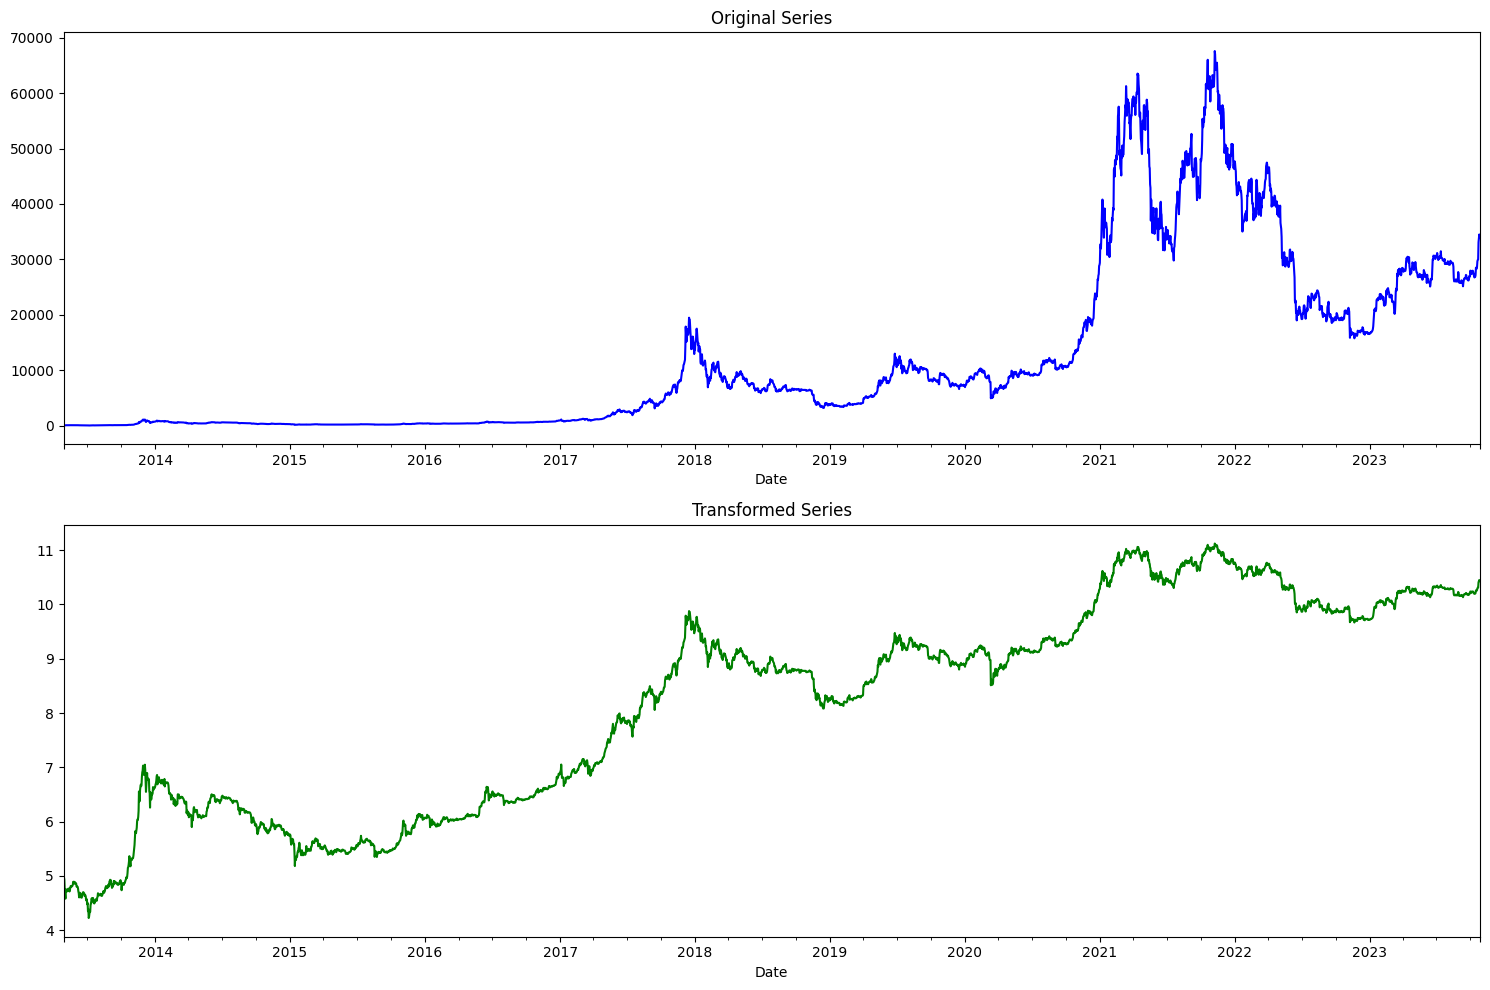


Diagnostics for Stationary Series:
--- ADF ---
Statistic: -1.3364141295979672
p-value: 0.6123525972233044
Critical Values: {'1%': -3.432067058537759, '5%': -2.862298702112663, '10%': -2.5671738669842252}
Conclusion: The time series appears to be non-stationary based on the ADF test. Differencing might be needed to make it stationary.
Guidance: Consider applying differencing or transformation to achieve stationarity.


--- Jarque-Bera ---
Statistic: 318.843516954289
p-value: 5.807777876800862e-70
Conclusion: The time series does not appear to be normally distributed based on the Jarque-Bera test.
Guidance: Consider transforming the series or using models that do not assume normality.


--- KPSS ---
Statistic: 8.823796254554303
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Conclusion: The time series appears to be non-stationary based on the KPSS test. It might have a unit root.
Guidance: Consider differencing or detrending the series to achieve 

In [18]:
# Instantiate the TimeSeriesAnalysis class
tsa = TimeSeriesAnalysis1(btc_data, target='Close')

# Check the diagnostics on the original series
print("Diagnostics for Original Series:")
original_diagnostics = tsa.diagnostic_check()

# Make the series stationary and update the data attribute
stationary_series = tsa.make_stationary(method='log')
tsa.data[tsa.target] = stationary_series

# Visualize the series after transformation
tsa.visualize_stationarity(show_plot=True)

# Create a new instance with the stationary series
tsa_stationary = TimeSeriesAnalysis1(pd.DataFrame({tsa.target: stationary_series}), target=tsa.target)

# Check the diagnostics on the stationary series
print("\nDiagnostics for Stationary Series:")
stationary_diagnostics = tsa_stationary.diagnostic_check()


In [ ]:
stop

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

class TimeSeriesAnalysis:
    """
    A class to perform various time series analysis tasks such as stationarity checks, volatility modeling, and decomposition.

    Attributes:
        data (pd.DataFrame): Time series data.
        target (str): Target column for time series analysis.
    """

    def __init__(self, data, target):
        """
        Initialize the TimeSeriesAnalysis class.

        Parameters:
            data (pd.DataFrame): Time series data.
            target (str): Target column for time series analysis.
        """
        logger.info("Initializing TimeSeriesAnalysis class")
        if target not in data.columns:
            raise ValueError(f"'{target}' is not a column in the provided data.")
        self.data = data
        self.target = target
        self.alpha = 0.05  

    def check_autocorrelation(self):
        """
        Check the autocorrelation of the time series using ACF and PACF plots.

        Returns:
            tuple: ACF and PACF figures.
        """
        logger.info("Checking autocorrelation of the time series")
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
        plot_acf(self.data[self.target], lags=50, alpha=0.05, ax=ax1)
        ax1.set_title("ACF for {}".format(self.target))
        plot_pacf(self.data[self.target], lags=50, alpha=0.05, method='ols', ax=ax2)
        ax2.set_title("PACF for {}".format(self.target))
        self.save_and_show_plot(fig, 'autocorrelation.png')
        return fig
    
    def decompose_time_series(self, model='additive', period=30, show=True):
        """
        Decompose the time series data into trend, seasonal, and residual components.

        Parameters:
            model (str): The type of decomposition model ('additive' or 'multiplicative').
            period (int): The period for seasonal decomposition.
            show (bool): Whether to display the plot.
        Returns:
            fig (matplotlib.Figure): The figure object containing the decomposition plots.
        """
        logger.info("Decomposing the time series")
        result = seasonal_decompose(self.data[self.target], model=model, period=period)

        # Adjusting the figsize here
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

        result.observed.plot(ax=ax1)
        ax1.set_title('Observed')
        result.trend.plot(ax=ax2)
        ax2.set_title('Trend')
        result.seasonal.plot(ax=ax3)
        ax3.set_title('Seasonal')
        result.resid.plot(ax=ax4)
        ax4.set_title('Residual')

        self.save_and_show_plot(fig, 'decompose.png', show=show)

        return fig
        
    def save_and_show_plot(self, fig, filename, show=True):
        """
        Utility method to save and display the plot.

        Parameters:
            fig (matplotlib.figure.Figure): The plot figure.
            filename (str): Filename to save the plot.
            show (bool, optional): Whether to display the plot. Default is True.
        """
        if not os.path.exists('ts_plots_assets'):
            os.makedirs('ts_plots_assets')
        path = os.path.join('ts_plots_assets', filename)
        fig.savefig(path)
        logger.info(f"Plot saved to: {path}")
        if show:
            plt.show()

    def diagnostic_check(self, alpha=None):
        alpha = alpha if alpha is not None else self.alpha
        
        # Augmented Dickey-Fuller test
        adf_result = adfuller(self.data[self.target])
        if adf_result[1] <= alpha:
            adf_conclusion = "The time series appears to be stationary based on the ADF test."
        else:
            adf_conclusion = "The time series appears to be non-stationary based on the ADF test. Differencing might be needed to make it stationary."
        
        # Jarque-Bera test
        jb_value, p_value = jarque_bera(self.data[self.target])
        if p_value > alpha:
            jb_conclusion = "The time series seems to follow a normal distribution based on the Jarque-Bera test."
        else:
            jb_conclusion = "The time series does not appear to be normally distributed based on the Jarque-Bera test."
        
        # KPSS test
        kpss_value, kpss_p_value, _, kpss_crit = kpss(self.data[self.target])
        if kpss_p_value > alpha:
            kpss_conclusion = "The time series appears to be stationary around a constant or trend based on the KPSS test."
        else:
            kpss_conclusion = "The time series appears to be non-stationary based on the KPSS test. It might have a unit root."
        
        # Kolmogorov-Smirnov test
        ks_value, ks_p_value = kstest(self.data[self.target], 'norm')
        if ks_p_value > alpha:
            ks_conclusion = "The time series appears to follow a normal distribution based on the Kolmogorov-Smirnov test."
        else:
            ks_conclusion = "The time series does not seem to follow a normal distribution based on the Kolmogorov-Smirnov test."
    
        # Create the results dictionary first
        results = {
            'ADF': {
                'Statistic': adf_result[0],
                'p-value': adf_result[1],
                'Critical Values': adf_result[4],
                'Conclusion': adf_conclusion
            },
            'Jarque-Bera': {
                'Statistic': jb_value,
                'p-value': p_value,
                'Conclusion': jb_conclusion
            },
            'KPSS': {
                'Statistic': kpss_value,
                'p-value': kpss_p_value,
                'Critical Values': kpss_crit,
                'Conclusion': kpss_conclusion
            },
            'Kolmogorov-Smirnov': {
                'Statistic': ks_value,
                'p-value': ks_p_value,
                'Conclusion': ks_conclusion
            }
        }
    
        # Check for Seasonality using ACF
        lag_acf = acf(self.data[self.target], nlags=40)
        lag_pacf = pacf(self.data[self.target], nlags=40, method='ols')
    
        # If there are significant peaks at regular intervals in ACF, we can suspect seasonality
        seasonality_conclusion = "Seasonality is likely present in the time series." if any(lag_acf > 0.2) else "Seasonality is likely not present in the time series."
    
        # Now, update the results dictionary with the seasonality check
        results['Seasonality'] = {
            'Conclusion': seasonality_conclusion
        }
    
        # Output to console
        for test, result in results.items():
            print(f"--- {test} ---")
            for key, value in result.items():
                print(f"{key}: {value}")
            print("\n")
    
        return results


    def check_garch(self, p=1, q=1, return_residuals=False):
        """
        Check volatility using GARCH model.

        Parameters:
            p (int, optional): The number of lag observations to include in the GARCH model. Default is 1.
            q (int, optional): The number of lag forecast errors to include in the GARCH model. Default is 1.
            return_residuals (bool, optional): Whether to return residuals of the GARCH model. Default is False.

        Returns:
            str or pd.Series: Summary of the GARCH model fit, or residuals if return_residuals is True.
        """
        logger.info("Checking volatility of the time series")
        try:
            model = arch_model(self.data[self.target], vol='Garch', p=p, q=q)
            model_fit = model.fit(disp='off')
            summary_str = model_fit.summary().as_text()
            print(summary_str)
            if return_residuals:
                return model_fit.resid
            else:
                return summary_str
        except Exception as e:
            print(f"Error encountered: {e}")
            return f"Error encountered: {e}"


    def test_granger_causality(self, other_column, maxlag=30, verbose=False):
        """Test Granger Causality between target and another time series column.
        
        Parameters:
            other_column (str): The name of the other column to test for Granger Causality.
            maxlag (int): The maximum number of lags to consider for the test.
            verbose (bool): Whether to display detailed output.
        
        Returns:
            dict: A dictionary containing the Granger Causality test results.
        """
        logger.info("Testing Granger causality")
        if other_column not in self.data.columns:
            raise ValueError(f"'{other_column}' is not a column in the provided data.")
        other_data = self.data[other_column].values
        target_data = self.data[self.target].values
        data = np.column_stack((target_data, other_data))
        result = grangercausalitytests(data, maxlag=maxlag, verbose=verbose)
        return result
    
    
    def concise_granger_output_table(self, granger_results):
        """Generate a concise report from the Granger Causality test results in a table format."""
        table_content = ['<table border="1" style="border-collapse:collapse;">']
        lags = list(granger_results.keys())
        for i in range(0, len(lags), 6):
            table_content.append('<tr>')
            for j in range(6):
                if i + j < len(lags):
                    lag = lags[i + j]
                    test_statistics = granger_results[lag][0]
                    cell_content = (f"<b>Lag: {lag}</b><br>"
                                    f"ssr_ftest: F={test_statistics['ssr_ftest'][0]:.4f}, p={test_statistics['ssr_ftest'][1]:.4f}<br>"
                                    f"ssr_chi2test: chi2={test_statistics['ssr_chi2test'][0]:.4f}, p={test_statistics['ssr_chi2test'][1]:.4f}<br>"
                                    f"lrtest: chi2={test_statistics['lrtest'][0]:.4f}, p={test_statistics['lrtest'][1]:.4f}<br>"
                                    f"params_ftest: F={test_statistics['params_ftest'][0]:.4f}, p={test_statistics['params_ftest'][1]:.4f}")
                    table_content.append(f'<td style="padding: 8px; text-align: left;">{cell_content}</td>')
            table_content.append('</tr>')
        table_content.append('</table>')
        return "\n".join(table_content)
    
    def make_stationary(self, method='diff', seasonal_period=None):
        """
        Make the time series stationary.

        Parameters:
            method (str): The method used to make the series stationary. Options are 'diff' (differencing), 
                          'seasonal_diff' (seasonal differencing), 'log' (log transformation), 'sqrt' (square root transformation).
            seasonal_period (int, optional): The period of the seasonality, used for seasonal differencing.

        Returns:
            pd.Series: The transformed time series.
        """
        if method == 'diff':
            return self.data[self.target].diff().dropna()
        elif method == 'seasonal_diff' and seasonal_period:
            return self.data[self.target].diff(seasonal_period).dropna()
        elif method == 'log':
            return np.log(self.data[self.target]).dropna()
        elif method == 'sqrt':
            return np.sqrt(self.data[self.target]).dropna()
        else:
            raise ValueError("Invalid method or missing seasonal_period for seasonal differencing.")
    


In [ ]:
# Instantiate the TimeSeriesAnalysis class
tsa = TimeSeriesAnalysis(btc_data, target='Close')

# Check the diagnostics on the original series
print("Diagnostics for Original Series:")
original_diagnostics = tsa.diagnostic_check()

# Make the series stationary
tsa.make_stationary(method = 'log')

# Check the diagnostics on the stationary series
print("\nDiagnostics for Stationary Series:")
stationary_diagnostics = tsa.diagnostic_check()

In [ ]:
class TimeSeriesAnalysis:
    """
    A class to perform various time series analysis tasks such as stationarity checks, volatility modeling, and decomposition.

    Attributes:
        data (pd.DataFrame): Time series data.
        target (str): Target column for time series analysis.
    """

    def __init__(self, data, target):
        """
        Initialize the TimeSeriesAnalysis class.

        Parameters:
            data (pd.DataFrame): Time series data.
            target (str): Target column for time series analysis.
        """
        if target not in data.columns:
            raise ValueError(f"'{target}' is not a column in the provided data.")
        self.original_data = data.copy()
        self.data = data
        self.target = target
        self.alpha = 0.05  

    def check_autocorrelation(self, show_plot=True):
        """
        Check the autocorrelation of the time series using ACF and PACF plots.

        Returns:
            tuple: ACF and PACF figures.
        """
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
        plot_acf(self.data[self.target], lags=50, alpha=0.05, ax=ax1)
        ax1.set_title("ACF for {}".format(self.target))
        plot_pacf(self.data[self.target], lags=50, alpha=0.05, method='ols', ax=ax2)
        ax2.set_title("PACF for {}".format(self.target))
        self.save_and_show_plot(fig, 'autocorrelation.png', show=show_plot)
        return fig
    
    def decompose_time_series(self, model='additive', period=None, show=True):
        """
        Decompose the time series data into trend, seasonal, and residual components.
    
        Parameters:
            model (str): The type of decomposition model ('additive' or 'multiplicative').
            period (int): The period for seasonal decomposition. If None, it will be inferred.
            show (bool): Whether to display the plot.
        Returns:
            dict: A dictionary containing decomposition components and guidance.
        """
        logger.info("Decomposing the time series")
        if period is None:
            # Attempt to infer the seasonal period
            period = self.infer_seasonal_period()
            
        result = seasonal_decompose(self.data[self.target], model=model, period=period)
    
        # Adjusting the figsize here
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
    
        result.observed.plot(ax=ax1)
        ax1.set_title('Observed')
        result.trend.plot(ax=ax2)
        ax2.set_title('Trend')
        result.seasonal.plot(ax=ax3)
        ax3.set_title('Seasonal')
        result.resid.plot(ax=ax4)
        ax4.set_title('Residual')
    
        self.save_and_show_plot(fig, 'decompose.png', show=show)
        
        # Analyzing the decomposition results
        guidance = self.analyze_decomposition(result)
        
        # Returning the decomposition components and guidance
        return {
            'Observed': result.observed,
            'Trend': result.trend,
            'Seasonal': result.seasonal,
            'Residual': result.resid,
            'Guidance': guidance
        }

    def analyze_decomposition(self, decomposition_result):
        """
        Analyze the time series decomposition results and provide guidance.
    
        Parameters:
            decomposition_result (DecomposeResult): The result from seasonal decomposition.
    
        Returns:
            str: Guidance based on the decomposition results.
        """
        guidance = ""
        
        # Analyzing the trend component
        if decomposition_result.trend.isnull().sum() > 0:
            guidance += "The trend component has missing values at the boundaries. Consider using a different decomposition method or filling the missing values.\n"
        else:
            trend_strength = np.nanmean(np.abs(decomposition_result.trend - np.nanmean(decomposition_result.trend)))
            if trend_strength > 0.05 * np.nanmean(decomposition_result.observed):
                guidance += "The trend component is strong. Consider detrending the series if you intend to use models that assume stationarity.\n"
            else:
                guidance += "The trend component is weak, indicating a relatively stable mean over time.\n"
                
        # Analyzing the seasonal component
        seasonal_strength = np.nanmean(np.abs(decomposition_result.seasonal - np.nanmean(decomposition_result.seasonal)))
        if seasonal_strength > 0.05 * np.nanmean(decomposition_result.observed):
            guidance += "The seasonal component is strong. Consider seasonal adjustment or using models that can handle seasonality.\n"
        else:
            guidance += "The seasonal component is weak, indicating that seasonality may not be a significant factor.\n"
            
        # Analyzing the residual component
        if decomposition_result.resid.isnull().sum() > 0:
            guidance += "The residual component has missing values at the boundaries. Consider using a different decomposition method or filling the missing values.\n"
        else:
            if np.nanstd(decomposition_result.resid) > 0.05 * np.nanmean(decomposition_result.observed):
                guidance += "The residual component shows variability. Consider further analysis to identify any remaining patterns or anomalies.\n"
            else:
                guidance += "The residual component is relatively stable, indicating that most of the patterns have been captured by the trend and seasonal components.\n"
                
        return guidance
        
    def save_and_show_plot(self, fig, filename, show=True):
        """
        Utility method to save and display the plot.

        Parameters:
            fig (matplotlib.figure.Figure): The plot figure.
            filename (str): Filename to save the plot.
            show (bool, optional): Whether to display the plot. Default is True.
        """
        if not os.path.exists('ts_plots_assets'):
            os.makedirs('ts_plots_assets')
        path = os.path.join('ts_plots_assets', filename)
        fig.savefig(path)
        if show:
            plt.show()

    def diagnostic_check(self, alpha=None):
        alpha = alpha if alpha is not None else self.alpha
        
        # Augmented Dickey-Fuller test
        adf_result = adfuller(self.data[self.target])
        if adf_result[1] <= alpha:
            adf_conclusion = "The time series appears to be stationary based on the ADF test."
            adf_guidance = "You might not need to difference the time series. However, consider checking other diagnostics and plots to confirm."
        else:
            adf_conclusion = "The time series appears to be non-stationary based on the ADF test. Differencing might be needed to make it stationary."
            adf_guidance = "Consider applying differencing or transformation to achieve stationarity."
        
        # Jarque-Bera test
        jb_value, p_value = jarque_bera(self.data[self.target])
        if p_value > alpha:
            jb_conclusion = "The time series seems to follow a normal distribution based on the Jarque-Bera test."
            jb_guidance = "The normality assumption holds. This is good if you plan to use models that assume normally distributed residuals."
        else:
            jb_conclusion = "The time series does not appear to be normally distributed based on the Jarque-Bera test."
            jb_guidance = "Consider transforming the series or using models that do not assume normality."
        
        # KPSS test
        kpss_value, kpss_p_value, _, kpss_crit = kpss(self.data[self.target])
        if kpss_p_value > alpha:
            kpss_conclusion = "The time series appears to be stationary around a constant or trend based on the KPSS test."
            kpss_guidance = "The series might be stationary. However, consider other diagnostics to confirm."
        else:
            kpss_conclusion = "The time series appears to be non-stationary based on the KPSS test. It might have a unit root."
            kpss_guidance = "Consider differencing or detrending the series to achieve stationarity."
        
        # Kolmogorov-Smirnov test
        ks_value, ks_p_value = kstest(self.data[self.target], 'norm')
        if ks_p_value > alpha:
            ks_conclusion = "The time series appears to follow a normal distribution based on the Kolmogorov-Smirnov test."
            ks_guidance = "The normality assumption holds, which is beneficial for certain statistical models."
        else:
            ks_conclusion = "The time series does not seem to follow a normal distribution based on the Kolmogorov-Smirnov test."
            ks_guidance = "Consider transforming the series or using models that do not assume normality."
    
        # Create the results dictionary
        results = {
            'ADF': {
                'Statistic': adf_result[0],
                'p-value': adf_result[1],
                'Critical Values': adf_result[4],
                'Conclusion': adf_conclusion,
                'Guidance': adf_guidance
            },
            'Jarque-Bera': {
                'Statistic': jb_value,
                'p-value': p_value,
                'Conclusion': jb_conclusion,
                'Guidance': jb_guidance
            },
            'KPSS': {
                'Statistic': kpss_value,
                'p-value': kpss_p_value,
                'Critical Values': kpss_crit,
                'Conclusion': kpss_conclusion,
                'Guidance': kpss_guidance
            },
            'Kolmogorov-Smirnov': {
                'Statistic': ks_value,
                'p-value': ks_p_value,
                'Conclusion': ks_conclusion,
                'Guidance': ks_guidance
            }
        }
    
        # Check for Seasonality using ACF
        lag_acf = acf(self.data[self.target], nlags=40)
        lag_pacf = pacf(self.data[self.target], nlags=40, method='ols')
    
        # If there are significant peaks at regular intervals in ACF, we can suspect seasonality
        seasonality_conclusion = "Seasonality is likely present in the time series." if any(lag_acf > 0.2) else "Seasonality is likely not present in the time series."
    
        # Now, update the results dictionary with the seasonality check
        results['Seasonality'] = {
            'Conclusion': seasonality_conclusion
        }
    
        # Output to console
        for test, result in results.items():
            print(f"--- {test} ---")
            for key, value in result.items():
                print(f"{key}: {value}")
            print("\n")
    
        return results

    def make_stationary(self, method='diff', seasonal_period=None):
        """
        Make the time series stationary.

        Parameters:
            method (str): The method used to make the series stationary. Options are 'diff' (differencing), 
                          'seasonal_diff' (seasonal differencing), 'log' (log transformation), 'sqrt' (square root transformation).
            seasonal_period (int, optional): The period of the seasonality, used for seasonal differencing.

        Returns:
            pd.Series: The transformed time series.
        """
        if method == 'diff':
            self.data[self.target] = self.data[self.target].diff().dropna()
        elif method == 'seasonal_diff' and seasonal_period:
            self.data[self.target] = self.data[self.target].diff(seasonal_period).dropna()
        elif method == 'log':
            self.data[self.target] = np.log(self.data[self.target]).dropna()
        elif method == 'sqrt':
            self.data[self.target] = np.sqrt(self.data[self.target]).dropna()
        else:
            raise ValueError("Invalid method or missing seasonal_period for seasonal differencing.")
        return self.data[self.target]

    def visualize_stationarity(self, show_plot=True):
        """
        Visualize the series before and after making it stationary.

        Parameters:
            show_plot (bool): Whether to display the plot.
        
        Returns:
            matplotlib.Figure: The generated figure.
        """
        fig, ax = plt.subplots(2, 1, figsize=(15, 10))

        # Plot original data
        self.original_data[self.target].plot(ax=ax[0], title='Original Series', color='blue')
        
        # Plot transformed data
        self.data[self.target].plot(ax=ax[1], title='Transformed Series', color='green')
        
        plt.tight_layout()
        self.save_and_show_plot(fig, 'stationarity_comparison.png', show=show_plot)
        
        return fig


In [ ]:
# Instantiate the TimeSeriesAnalysis class
tsa = TimeSeriesAnalysis(btc_data, target='Close')
# Check the diagnostics on the original series
print("Diagnostics for Original Series:")
original_diagnostics = tsa.diagnostic_check()

# Make the series stationary
tsa.make_stationary(method='log')

# Visualize the series after transformation
tsa.visualize_stationarity(show_plot=True)

# Check the diagnostics on the stationary series
print("\nDiagnostics for Stationary Series:")
stationary_diagnostics = tsa.diagnostic_check()